In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()

In [5]:
chars = sorted(list(set(''.join(words))))

In [6]:
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [7]:
# build dataset

block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [8]:
# split into splits

import random
random.seed(21476891001)
random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [9]:
# MLP impl
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # dimensionality of neurons in the hidden layer

g = torch.Generator().manual_seed(21476891001)
C = torch.randn((vocab_size, n_embd), generator=g) 
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [10]:
# optimization / training
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # train with mini batches
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # == torch.cat(torch.unbind(emb, 1), 1) - cat() allocates to a new memory
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += p.grad * -lr
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.item())

      0/ 200000: 32.373756
  10000/ 200000: 2.273057
  20000/ 200000: 2.366470
  30000/ 200000: 2.445637
  40000/ 200000: 2.571612
  50000/ 200000: 3.012252
  60000/ 200000: 2.387527
  70000/ 200000: 2.300509
  80000/ 200000: 1.915353
  90000/ 200000: 2.184172
 100000/ 200000: 1.904131
 110000/ 200000: 2.203095
 120000/ 200000: 1.929948
 130000/ 200000: 1.947637
 140000/ 200000: 1.916010
 150000/ 200000: 2.126239
 160000/ 200000: 2.096614
 170000/ 200000: 2.090429
 180000/ 200000: 2.012115
 190000/ 200000: 1.772163


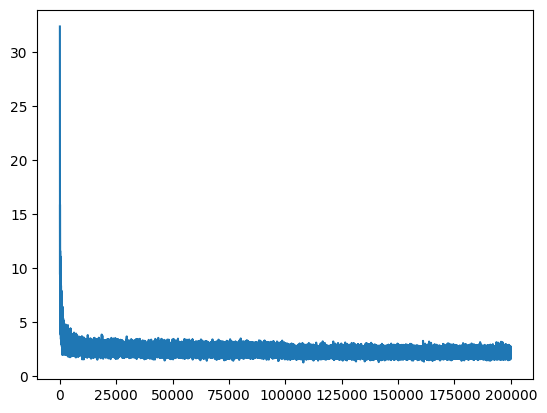

In [11]:
plt.plot(lossi)

In [12]:
@torch.no_grad() # disables grad tracking, no need to maintain the graph
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x] #[embdn, block_size, ]
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1293065547943115
val 2.161168336868286


In [16]:
# sample from the model
g = torch.Generator().manual_seed(21476891001)

for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor(context)] #(1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break;
    print(''.join(itos[i] for i in out))

emyna.
onatte.
sharyco.
contemuzsien.
wille.
kean.
jora.
milah.
coion.
sta.
kafarre.
inda.
thyana.
ash.
ini.
ire.
anjienn.
devers.
erianna.
mutthrysba.
